<a href="https://colab.research.google.com/github/m-raza23/song_popularity_predictor/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import ast

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from scipy.stats import uniform, randint as sp_randint

In [ ]:
df=pd.read_csv("/content/data .csv")

In [ ]:
#sa,pling the data into half
df = df.sample(frac=0.5, random_state=42).reset_index(drop=True)

In [ ]:
df.shape

(87194, 19)

In [ ]:
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.9060,"['Gioachino Rossini', 'Academy of St. Martin i...",0.322,425000,0.140,0,1chTrqszWQEOP4RsNuOZf7,0.759000,4,0.1250,-20.747,1,Il barbiere di Siviglia: Overture (Sinfonia),51,2003-01-01,0.0489,92.122,0.285,2003
1,0.1270,['Pretenders'],0.545,297866,0.552,0,5go7pj7RuuNBsZRaI86hZl,0.000000,0,0.1050,-9.351,1,Hymn to Her - 2007 Remaster,52,1986-11-04,0.0346,95.166,0.243,1986
2,0.9290,['David-Trio'],0.221,443025,0.139,0,6EfzLgkvpTlnu1LhOoEEOe,0.835000,2,0.1150,-18.445,0,Streichtrio Nr. 3 - I. Adagio - Allegro modera...,0,1948,0.0488,149.339,0.115,1948
3,0.4320,['Elton John'],0.601,281613,0.532,0,3gdewACMIVMEWVbyb8O9sY,0.000006,10,0.0925,-9.119,1,"Rocket Man (I Think It's Going To Be A Long, L...",81,1972-05-19,0.0286,136.571,0.341,1972
4,0.0012,['TOOL'],0.567,403533,0.714,0,55mJleti2WfWEFNFcBduhc,0.417000,9,0.1860,-8.512,0,Schism,67,2001-05-15,0.0302,107.441,0.191,2001


In [ ]:
df.dtypes

,0
acousticness,float64
artists,object
danceability,float64
duration_ms,int64
energy,float64
explicit,int64
id,object
instrumentalness,float64
key,int64
liveness,float64


As you can see there is many problems in the data such as the release date structure as well the artists is stored in form of Object instead of string so firt we need to fix these as well some of the release date only contains the year in which it was released.

In [ ]:
# first changing all the date column in one format so the model does not give error
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

In [ ]:
# Here We assume the missing month/day is July 1st (mid-year). and swap those entries existing with only year
df['release_date'] = df['release_date'].fillna(
    pd.to_datetime(df['year'].astype(str) + '-07-01', errors='coerce')
)

In [ ]:
# 3. Calculate Recency
reference_date = pd.to_datetime('2022-01-01')
df['days_since_release'] = (reference_date - df['release_date']).dt.days

In [ ]:
# Final cleanup for recency: fill any remaining NaN (should be none) with median,
# and clip negative values to 0.
median_recency = df['days_since_release'].median()
df['days_since_release'] = df['days_since_release'].fillna(median_recency)
df['days_since_release'] = np.where(df['days_since_release'] < 0, 0, df['days_since_release'])

In [ ]:
# safely convert the artist list, which is stored as a messy text string in the original data, into a usable Python list so we can extract the name of the primary artist.
def extract_main_artist(artist_list_str):
    """Safely extracts the first artist from a string representation of a list."""
    try:
        artists = ast.literal_eval(artist_list_str)
        if isinstance(artists, list) and artists:
            return artists[0]
        return 'Unknown Artist'
    except:
        return 'Unknown Artist'
# calling the function and saving it in new column as main_artist
df['main_artist'] = df['artists'].apply(extract_main_artist)

In [ ]:
df

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,mode,name,popularity,release_date,speechiness,tempo,valence,year,days_since_release,main_artist
0,0.906000,"['Gioachino Rossini', 'Academy of St. Martin i...",0.322,425000,0.140,0,1chTrqszWQEOP4RsNuOZf7,0.759000,4,0.1250,...,1,Il barbiere di Siviglia: Overture (Sinfonia),51,2003-01-01,0.0489,92.122,0.285,2003,6940,Gioachino Rossini
1,0.127000,['Pretenders'],0.545,297866,0.552,0,5go7pj7RuuNBsZRaI86hZl,0.000000,0,0.1050,...,1,Hymn to Her - 2007 Remaster,52,1986-11-04,0.0346,95.166,0.243,1986,12842,Pretenders
2,0.929000,['David-Trio'],0.221,443025,0.139,0,6EfzLgkvpTlnu1LhOoEEOe,0.835000,2,0.1150,...,0,Streichtrio Nr. 3 - I. Adagio - Allegro modera...,0,1948-07-01,0.0488,149.339,0.115,1948,26847,David-Trio
3,0.432000,['Elton John'],0.601,281613,0.532,0,3gdewACMIVMEWVbyb8O9sY,0.000006,10,0.0925,...,1,"Rocket Man (I Think It's Going To Be A Long, L...",81,1972-05-19,0.0286,136.571,0.341,1972,18124,Elton John
4,0.001200,['TOOL'],0.567,403533,0.714,0,55mJleti2WfWEFNFcBduhc,0.417000,9,0.1860,...,0,Schism,67,2001-05-15,0.0302,107.441,0.191,2001,7536,TOOL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87189,0.968000,"['Francisco Canaro', 'Eduardo Adrian']",0.698,162773,0.157,0,36XDfycsW6poiE2pM4YPUe,0.625000,2,0.1010,...,1,Necesito Olvidar - Remasterizado,0,1943-03-12,0.0906,128.968,0.597,1943,28785,Francisco Canaro
87190,0.000108,['Metallica'],0.679,396107,0.716,0,0Zo0GJhGcT2qKFb5NxY3Vf,0.349000,9,0.1260,...,1,The Thing That Should Not Be (Remastered),49,1986-03-03,0.0313,111.827,0.485,1986,13088,Metallica
87191,0.982000,['Jelly Roll Morton & His Red Hot Peppers'],0.677,205729,0.323,0,68LmN842DekQRSDhNLJSH9,0.879000,9,0.4820,...,0,The Pearls - 1995 Remastered,2,1926-07-01,0.0793,147.847,0.882,1926,34883,Jelly Roll Morton & His Red Hot Peppers
87192,0.958000,['Kindan no Tasuketsu'],0.419,221542,0.410,0,3K2svTglkeMicGYJjAoELp,0.606000,0,0.3500,...,1,Koarashi Spin,1,2018-10-19,0.0276,67.001,0.111,2018,1170,Kindan no Tasuketsu


In [ ]:
# Dropping those columns which are not relevant to avoid Overfitting
columns_to_drop = [
    'id', 'name', 'artists', 'release_date', 'year'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [ ]:
df.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,days_since_release,main_artist
0,0.9060,0.322,425000,0.140,0,0.759000,4,0.1250,-20.747,1,51,0.0489,92.122,0.285,6940,Gioachino Rossini
1,0.1270,0.545,297866,0.552,0,0.000000,0,0.1050,-9.351,1,52,0.0346,95.166,0.243,12842,Pretenders
2,0.9290,0.221,443025,0.139,0,0.835000,2,0.1150,-18.445,0,0,0.0488,149.339,0.115,26847,David-Trio
3,0.4320,0.601,281613,0.532,0,0.000006,10,0.0925,-9.119,1,81,0.0286,136.571,0.341,18124,Elton John
4,0.0012,0.567,403533,0.714,0,0.417000,9,0.1860,-8.512,0,67,0.0302,107.441,0.191,7536,TOOL


Feature Engineering Done

In [ ]:
X=df.drop("popularity",axis=1)
y=df['popularity']

In [ ]:
# splitting data into 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
print(X_train.columns)

Index(['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence', 'days_since_release', 'main_artist'],
      dtype='object')


In [ ]:
# target encoding on popularity
train_data_for_encoding = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
artist_mean_popularity = train_data_for_encoding.groupby('main_artist')['popularity'].mean()
global_mean_popularity = y_train.mean()

# 2. Map and Fillna (creating the numerical 'artist_popularity' feature)
X_train['artist_popularity'] = X_train['main_artist'].map(artist_mean_popularity).fillna(global_mean_popularity)
X_test['artist_popularity'] = X_test['main_artist'].map(artist_mean_popularity).fillna(global_mean_popularity)

# 3. Drop the original categorical column (This fixes the XGBoost error!)
X_train.drop(columns=['main_artist'], inplace=True)
X_test.drop(columns=['main_artist'], inplace=True)

In [ ]:
# one hot encoding
categorical_cols = ['key', 'mode']

X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# B. Align Columns
X_train_encoded, X_test_encoded = X_train_encoded.align(
    X_test_encoded, join='left', axis=1, fill_value=0
)

# C. Scaling Numerical Features
numerical_features = X_train_encoded.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()
scaler.fit(X_train_encoded[numerical_features])
X_train_encoded[numerical_features] = scaler.transform(X_train_encoded[numerical_features])
X_test_encoded[numerical_features] = scaler.transform(X_test_encoded[numerical_features])

In [ ]:
# setting parameters for XGboost randomized search
param_distributions = {
    'n_estimators': sp_randint(100, 300),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': sp_randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

In [ ]:
# randomized searching for quick searching
xgb_random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42),
    param_distributions=param_distributions,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [ ]:
xgb_random_search.fit(X_train_encoded, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f30bc89c3b0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f30bc89d310>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f30bc89eab0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f30bc89eea0>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [ ]:
best_xgb_model = xgb_random_search.best_estimator_

In [ ]:
y_pred_tuned = best_xgb_model.predict(X_test_encoded)

In [ ]:
#calculating the error manually
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

In [ ]:
print(xgb_random_search.best_params_)
print("\n--- FINAL TUNED PERFORMANCE  ---")
print(f"New Root Mean Squared Error (RMSE): {rmse_tuned:.2f}")
print(f"New R-squared (R2 Score): {r2_tuned:.4f}")
print("-------------------------------------------")

{'colsample_bytree': np.float64(0.9140703845572055), 'learning_rate': np.float64(0.04993475643167195), 'max_depth': 9, 'n_estimators': 163, 'subsample': np.float64(0.786705157299192)}

--- FINAL TUNED PERFORMANCE  ---
New Root Mean Squared Error (RMSE): 10.98
New R-squared (R2 Score): 0.7496
-------------------------------------------


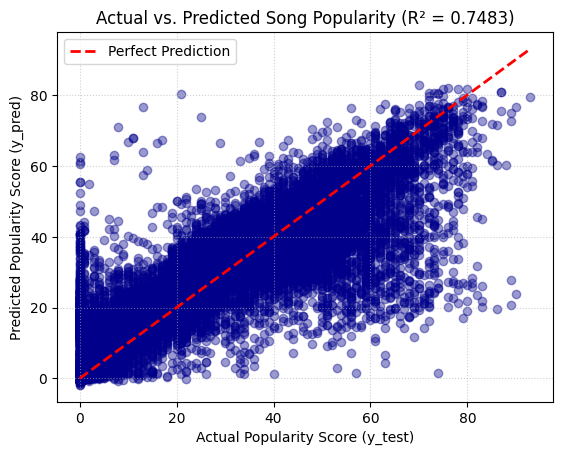

In [ ]:

plt.scatter(y_test, y_pred_tuned, alpha=0.4, color='darkblue')


plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Popularity Score (y_test)')
plt.ylabel('Predicted Popularity Score (y_pred)')
plt.title(f'Actual vs. Predicted Song Popularity (R² = 0.7483)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

Importance of Column Features in prediction:


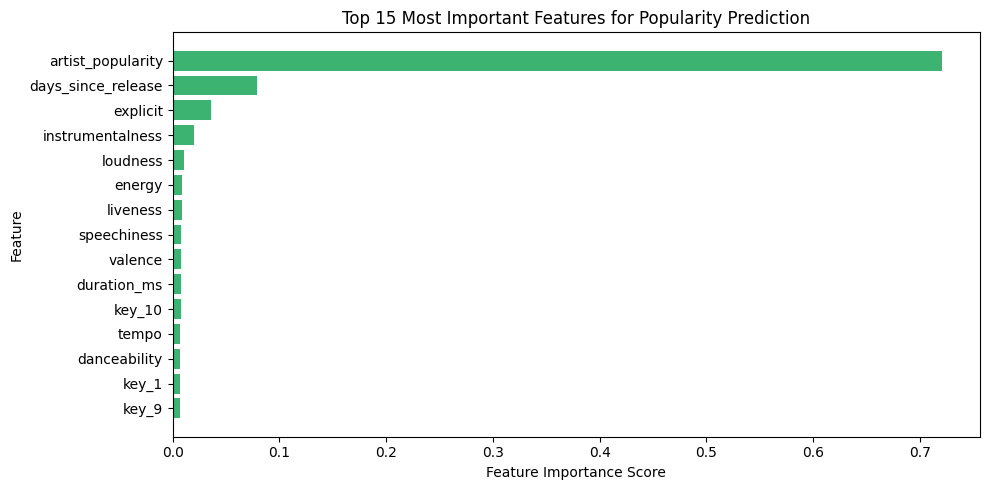

In [ ]:
print("Importance of Column Features in prediction:")
importances = best_xgb_model.feature_importances_
feature_names = X_test_encoded.columns

feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance score and select the top 15
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 5))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='mediumseagreen')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Top 15 Most Important Features for Popularity Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()